***Voter Inequality in Canada***

In [123]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Define some helper functions for parsing the 308.com data

In [124]:
def read_file(filename):
    f = open(filename, 'r')
    abc = f.readlines()
    f.close()
    return abc

def tab_separate(contents):
    xyz = []
    for a in contents:
        b = a.split("\t")
        xyz.append(b)
    return xyz

def remove_non_data_lines(sep_contents):
    a1 = []
    for x in sep_contents:
        if len([y for y in x if y == '']) < 2:
            a1.append(x)
    return a1

def get_riding_names(clean_contents):
    ridings = []
    for i in range(338):
        ridings.append(clean_contents[i*3+1][0])
    return ridings

Parse the 308.com data

In [125]:
abc = read_file('current_projections.txt')
xyz = tab_separate(abc)
a1 = remove_non_data_lines(xyz)
ridings = get_riding_names(a1)

In [126]:
import fednum_dict as fed

In [127]:
a2 = {v: k for k, v in fed.fednum_dict.items()} 

Manually set some ridings that are difficult to get automatically

In [128]:
found = {}
found['Haliburton – Kawaratha Lakes – Brock'] = 35034
found['Ahuntsic – Cartierville'] = 24003
found['Laval-Les \xceles'] = 24040 
found['Mont-Royal'] = 24052 
found["Ville-Marie – Le Sud-Ouest – L'Île-des-Soeurs"] = 24077 
found["Beauport – Côte-de-Beaupré – Île d'Orléans – Charlevoix"] = 24020
found['Portneuf – Jacques Cartier'] = 24058
found["South Shore – St. Margaret's"] = 12009

In [129]:
not_found = []
for r in ridings:
    if r not in found:
        if r in a2:
            #Riding is easily found in the 308.com data, add to dictionary
            found[r] = a2[r]
        else:
            #Try stripping astrix
            new = r.strip('*')
            if new in a2:
                found[r] = a2[new]
            else:
                #Failed to find the riding
                not_found.append(r)

Some sanity checking for the parsing

In [130]:
len(not_found)

0

In [131]:
len(found)

338

In [132]:
len(not_found)

0

In [133]:
len(set(found.keys()))

338

In [134]:
len(set(found.values()))

338

ridingForecast.py contains some classes for storing party forecasts and riding forecasts

In [135]:
import ridingForecast

In [136]:
ridingDict = ridingForecast.parseCleanForecasts(a1)

In [137]:
print(ridingDict['Mont-Royal'])

Mont-Royal
Winner: ('Liberal', 50.0) prob: 0.86

Conservative Party, low = 29.0, forecast = 30.5, high = 33.6
Liberal Party, low = 45.0, forecast = 50.0, high = 53.5
New Democratic Party, low = 14.3, forecast = 14.8, high = 16.0
Bloc Quebecois Party, low = 1.1, forecast = 1.2, high = 1.3
Green Party, low = 0.0, forecast = 0.0, high = 0.0
Other Party, low = 2.1, forecast = 2.4, high = 2.5


In [138]:
#Make sure all the ridings are in the dictionary
all([r in ridingDict for r in ridings])

True

Read in the Statistics Canada population data for the ridings

In [139]:
populations = pd.read_csv('ridingPopulations.csv')
populations.head()

,Riding,RidingName,Population
0,10001,Avalon,81540
1,10002,Bonavista–Burin–Trinity,76704
2,10003,Coast of Bays–Central–Notre Dame,78092
3,10004,Labrador,26728
4,10005,Long Range Mountains,87592


In [140]:
for riding in ridings:
    ridingDict[riding].population = float(populations[populations['Riding'] == found[riding]]['Population'])

The function for the value of a vote assumes that a voter forecast to cast a tie breaking vote in a riding has value 1.0. The value of other votes is 1.0 divided by the number of times they would need to vote for their party to win.

In [141]:
def voteValue(partyName, ridingFC):
    if partyName == ridingFC.getWinner()[0]:
        delta = ridingFC.getForecast(partyName) - ridingFC.getSecond()[1]
    else:
        delta = ridingFC.getWinner()[1] - ridingFC.getForecast(partyName)
    delta = max(0.05, delta)
    return 100.0/max(100.0,ridingFC.population*delta)

In [142]:
conValues = [(riding, voteValue("Conservative", ridingDict[riding])) for riding in ridings]
libValues = [(riding, voteValue("Liberal", ridingDict[riding])) for riding in ridings]
ndpValues = [(riding, voteValue("New Democratic", ridingDict[riding])) for riding in ridings]
blocValues = [(riding, voteValue("Bloc Quebecois", ridingDict[riding])) for riding in ridings]
greenValues = [(riding, voteValue("Green", ridingDict[riding])) for riding in ridings]
otherValues = [(riding, voteValue("Other", ridingDict[riding])) for riding in ridings]
#print(greenValues)
#print(sorted(ndpValues, key=lambda x: x[1]))

In [143]:
print(max(ndpValues, key=lambda x: x[1]))
print(min(ndpValues, key=lambda x: x[1]))

('Fleetwood – Port Kells', 0.009112281533050116)
('Battle River – Crowfoot', 1.4791730949064083e-05)


In [144]:
parties = ["Conservative", "Liberal", "New Democratic", "Bloc Quebecois", "Green", "Other"]

In [145]:
totalpop = sum([ridingDict[riding].population for riding in ridings])

Here we create an array containing the voting values of one in one thousand Canadian voters

In [146]:
voterPowers = np.zeros(32521)
i = 0
for riding in ridings:
    for party in parties:
        for person in range(
            int(ridingDict[riding].getForecast(party)/100.0
                *ridingDict[riding].population/1000.0)):
            voterPowers[i] = voteValue(party, ridingDict[riding])
            i += 1
            

The Lorenz curve is a common way of displaying inequality in a distribution. Basically, the plot visually represents statements in the form "the bottom 20% of all households have 10% of the total income.". This function computes the values of the Lorenz curve.

<a href="https://en.wikipedia.org/wiki/Lorenz_curve"> >Lorenz Curve</a>

In [147]:
def Lorenz(values):
    n = len(values)
    assert(n > 0), 'Empty list of values'
    sortedValues = sorted(values) #Sort smallest to largest

    #Find cumulative totals
    cumm = np.zeros(n+1)
    for i in range(n+1):
        cumm[i] = sum(sortedValues[0:(i + 1)])

    #Calculate Lorenz points
    LorenzPoints = [[], []]
    for i in range(1, n + 2):
        x = 100.0 * (i - 1)/n
        y = 100.0 * (cumm[i - 1]/float(cumm[n]))
        LorenzPoints[0].append(x)
        LorenzPoints[1].append(y)
    

    return LorenzPoints

In [148]:
len(voterPowers)

32521

In [149]:
lorenzPoints = Lorenz(voterPowers)

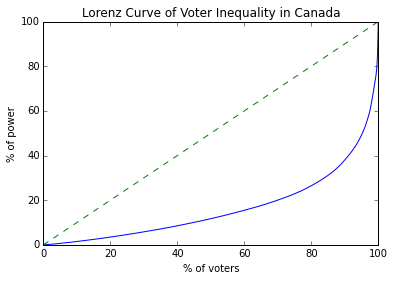

In [150]:
plt.plot(lorenzPoints[0], lorenzPoints[1], [0, 100], [0, 100], '--')
plt.xlabel('% of voters')
plt.ylabel('% of power')
plt.title("Lorenz Curve of Voter Inequality in Canada")
plt.show()

The Gini coefficient is a measure of the inequality represented by the Lorenz curve. It is basically the area between the green dotted line and the blue line, divided by the area under the green dotted line.

<a href="https://en.wikipedia.org/wiki/Gini_coefficient">Gini Coefficient</a>

Canada's wealth inequality Gini Coefficient is about 0.32. South Africa's weath inequality Gini Coefficient is about 0.65, the largest in the world.

In [151]:
def gini(list_of_values):
  """Compute the Gini coefficient given a list of values"""
  sorted_list = sorted(list_of_values)
  height, area = 0, 0
  for value in sorted_list:
    height += value
    area += height - value / 2.
  fair_area = height * len(list_of_values) / 2
  return (fair_area - area) / fair_area

In [152]:
print(gini(voterPowers))

0.673014839549


In [153]:
class voteSwap():
    """                                                                                                  
    Class for holding information about a swap between two ridings                                       
    """
    def	__init__(self, riding1=None, riding2=None, party1=None, party2=None):
        assert riding1 != riding2, "Ridings must be different"
        assert party1 != party2, "Parties must be different"
        self.riding1 = riding1
        self.riding2 = riding2
        self.party1 = party1
        self.party2 = party2
        benefit = self.value()
        self.totalBenefit = benefit[0]
        self.benefit1 =	benefit[1]
        self.benefit2 =	benefit[2]

    def value(self):
        #Compute the original values of the votes                                                        
        origVal1 = voteValue(self.party1, ridingDict[self.riding1])
        origVal2 = voteValue(self.party2, ridingDict[self.riding2])
        #Compute the new values of the swapped votes                                                     
        # Note that the first voter keeps his preferred party but is                                     
        # effectively voting in the second riding.                                                       
        newVal1 = voteValue(self.party1, ridingDict[self.riding2])
        newVal2 = voteValue(self.party2, ridingDict[self.riding1])
        #Return a tuple consisting of                                                                    
        # 0 - The total increased value because of the swap                                              
        # 1 - The value increase for the first voter                                                     
        # 2 - The value increase for the second voter                                                    
        benefit1 = newVal1 - origVal1
        benefit2 = newVal2 - origVal2
        return(benefit1 + benefit2, benefit1, benefit2)

A few examples:

An NDP voter in Calgary Centre might swap with a Liberal voter in Surrey Centre. These are both swing ridings. Both voters benefit from the transaction.

In [154]:
voteSwap("Calgary Centre", "Surrey Centre", "New Democratic", "Liberal").value()

(0.0002903916521580131, 0.00014192483160623876, 0.00014846682055177433)

Reversing the above transaction will disadvantage both swappers

In [155]:
voteSwap("Calgary Centre", "Surrey Centre", "Liberal", "New Democratic").value()

(-0.0002903916521580131, -0.00014846682055177433, -0.00014192483160623876)

In [156]:
voteSwap("Calgary Centre", "Vancouver Quadra", "Liberal", "Conservative").value()

(0.0, -0.00030695340708565284, 0.00030695340708565284)

A Liberal voter in the Liberal safe riding of Vancouver Quadra may wish to send their vote to the swing riding Calgary Centre where it will have more influence. What if they swap with a NDP voter in that riding? The Liberal voter sees a large benefit, while the NDP voter sees a small disadvantage. The net gain in vote value is positive, but will the NDP voter agree to this for the greater good?

In [157]:
voteSwap("Calgary Centre", "Vancouver Quadra", "New Democratic", "Liberal").value()

(0.0002877001197672217, -1.9253287318431152e-05, 0.00030695340708565284)

Let's loop through all possible swaps and compute the value of each swap

In [158]:
import itertools as it
swaps = list()
for item in it.product(ridings, ridings, parties, parties):
    if item[0] != item[1] and item[2] != item[3]:
        swaps.append(voteSwap(item[0], item[1], item[2], item[3]))

Now, we will generate a sorted list of all the swaps

In [159]:
sortedSwaps = sorted(swaps, key=lambda x: x.totalBenefit, reverse=True)
for swap in sortedSwaps[0:20:2]:
    print("{} voters in {} should swap with {} voters in {}".format(
        swap.party1, swap.riding1, swap.party2, swap.riding2))
    print("The {} voter gains {} while the {} voter gains {}".format(
            swap.party1, swap.benefit1, swap.party2, swap.benefit2))
    print("")

Liberal voters in Fleetwood – Port Kells should swap with New Democratic voters in Kanata – Carleton
The Liberal voter gains 0.0009369933367937352 while the New Democratic voter gains 0.009070264119016905

Liberal voters in Fleetwood – Port Kells should swap with Conservative voters in Beaches – East York
The Liberal voter gains 0.0006877141429133034 while the Conservative voter gains 0.009073532722832334

Liberal voters in Fleetwood – Port Kells should swap with New Democratic voters in Markham – Stouffville
The Liberal voter gains 0.0006590471533026595 while the New Democratic voter gains 0.009074795412286328

Liberal voters in Fleetwood – Port Kells should swap with New Democratic voters in Tobique – Mactaquac
The Liberal voter gains 0.0007002302997380979 while the New Democratic voter gains 0.008974826302218799

Liberal voters in Fleetwood – Port Kells should swap with New Democratic voters in Brampton Centre
The Liberal voter gains 0.0005978786571959774 while the New Democratic vo

In [160]:
def plotSwap(swap):
    plt.bar([1,2], height=[swap.benefit1, swap.benefit2])
    plt.show()

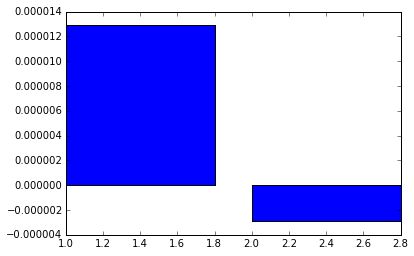

In [161]:
plotSwap(sortedSwaps[1000000])

In [162]:
len(sortedSwaps)

3417180